In [ ]:
# Run CPU-only, GPU code needs further testing
"""
Restart kernel after running
Only need to run once
"""
!pip install scikit-learn matplotlib seaborn

In [20]:
# hardcode if not using UGE environment
import os
num_cores_uge = os.environ.get('NSLOTS')
print(num_cores_uge)

num_workers = 7

15


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset


froot = './data/k562_chr16'

df = pd.read_csv(froot + ".csv")

In [5]:
print(df.head())

   seqnames   start     end strand  ensembl_gene_id  score      ctcf  \
0        16  245089  245089      +  ENSG00000167930    0.0 -0.039744   
1        16  245090  245090      +  ENSG00000167930    0.0 -0.039511   
2        16  245091  245091      +  ENSG00000167930    0.0 -0.039276   
3        16  245092  245092      +  ENSG00000167930    0.0 -0.039039   
4        16  245093  245093      +  ENSG00000167930    0.0 -0.038799   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts      wgbs  \
0 -0.429633  0.843669  0.003958  ... -0.057178 -0.307549  0.249626  0.000000   
1 -0.431173  0.851792  0.004639  ... -0.057178 -0.307549  0.249626  0.550271   
2 -0.432698  0.859971  0.005313  ... -0.057178 -0.307549  0.249626  0.000000   
3 -0.434205  0.868205  0.005981  ... -0.057178 -0.307549  0.249626  0.000000   
4 -0.435697  0.876495  0.006642  ... -0.057178 -0.307549  0.249626  0.000000   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625 -0.678443  

In [6]:
column_names = np.array(df.columns)
feature_names = column_names[6:-6]
num_features = len(feature_names)
nucleotides = column_names[-6:-2]
print(feature_names)
print(nucleotides)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['ctcf' 'h3k36me3' 'h3k4me1' 'h3k79me2' 'h3k9me1' 'h3k9me3' 'h4k20me1'
 'sj5' 'sj3' 'dms' 'rpts' 'wgbs']
['A' 'T' 'G' 'C']


In [7]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 435797


In [8]:
print("Number of Features: " + str(num_features))

Number of Features: 12


In [9]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-6].values

In [10]:
C_j = df['lambda_alphaj'].values

In [11]:
gene_ids = df['ensembl_gene_id'].values

In [12]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: False
Number of GPUs available: 0


In [13]:
class CustomDataset(Dataset):
    def __init__(self, GeneId, Y_ji, X_ji, C_j, Z_ji):
        self.GeneId = GeneId
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji
        self.cache = {}  

    def __len__(self):
        return len(self.Y_ji)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        data = {
            'GeneId':  self.GeneId[idx],
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }
        self.cache[idx] = data
        return data

In [14]:
from sklearn.model_selection import GroupShuffleSplit

dataset = CustomDataset(gene_ids, Y_ji, X_ji, C_j, Z_ji)

# Convert gene IDs to numeric labels for GroupShuffleSplit
unique_genes = np.unique(gene_ids)
gene_to_idx = {gene: idx for idx, gene in enumerate(unique_genes)}
group_labels = np.array([gene_to_idx[gene] for gene in gene_ids])

gss_initial = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_idx, test_idx = next(gss_initial.split(np.zeros(len(group_labels)), groups=group_labels))

gss_final = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
train_idx, val_idx = next(gss_final.split(np.zeros(len(train_val_idx)), groups=group_labels[train_val_idx]))

train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

batch_size = 64

In [15]:
device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1)#, bias=False)

if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

print(model)

arr = torch.randn((batch_size,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

Linear(in_features=12, out_features=1, bias=True)
torch.Size([64, 1])
Number of parameters: 13
Model is on device: cpu


In [16]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji) - X_ji * torch.log(C_j)
        return (loss).mean()

In [ ]:
# GPU testing with larger datasets
"""
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

def print_profiler_results(profiler):
    print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    on_trace_ready=print_profiler_results,
    record_shapes=True,
    profile_memory=True
) as profiler:

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')
        model.train()
        trndl = DataLoader(train_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
        for i, batch in enumerate(trndl):
            optimizer.zero_grad()
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            profiler.step()
        loss_hist_train[epoch] /= len(trndl)
        del trndl

    model.eval()
    valdl = DataLoader(val_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')
          """

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    trndl = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True)
    for i, batch in enumerate(trndl):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
    loss_hist_train[epoch] /= len(trndl)
    del trndl

    model.eval()
    valdl = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')


Epoch 1
Epoch 1 trn_loss: 0.1164 val_loss: 0.1448
Epoch 2
Epoch 2 trn_loss: 0.1093 val_loss: 0.1431
Epoch 3
Epoch 3 trn_loss: 0.1049 val_loss: 0.1418
Epoch 4
Epoch 4 trn_loss: 0.1021 val_loss: 0.1409
Epoch 5
Epoch 5 trn_loss: 0.1004 val_loss: 0.1402
Epoch 6
Epoch 6 trn_loss: 0.0994 val_loss: 0.1396
Epoch 7
Epoch 7 trn_loss: 0.0987 val_loss: 0.1390
Epoch 8
Epoch 8 trn_loss: 0.0984 val_loss: 0.1385
Epoch 9
Epoch 9 trn_loss: 0.0981 val_loss: 0.1380
Epoch 10
Epoch 10 trn_loss: 0.0980 val_loss: 0.1376
Epoch 11
Epoch 11 trn_loss: 0.0979 val_loss: 0.1373
Epoch 12
Epoch 12 trn_loss: 0.0979 val_loss: 0.1370
Epoch 13
Epoch 13 trn_loss: 0.0978 val_loss: 0.1368
Epoch 14
Epoch 14 trn_loss: 0.0978 val_loss: 0.1367
Epoch 15
Epoch 15 trn_loss: 0.0978 val_loss: 0.1365
Epoch 16
Epoch 16 trn_loss: 0.0977 val_loss: 0.1365
Epoch 17
Epoch 17 trn_loss: 0.0977 val_loss: 0.1364
Epoch 18
Epoch 18 trn_loss: 0.0977 val_loss: 0.1364
Epoch 19
Epoch 19 trn_loss: 0.0977 val_loss: 0.1363
Epoch 20
Epoch 20 trn_loss: 0.

In [22]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/Elongation_Model_chr16.pth"#_{timestamp}.pth"
torch.save(model.state_dict(), filename)

In [25]:
"""
model = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("models/Elongation_Model_chr16.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
"""

CUDA (GPU support) is available: False
Number of GPUs available: 0
Model is on device: cpu


In [26]:
weights = model.weight.data.cpu().numpy()
bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

print("bias: " + str(model.bias.data))

"ctcf": -0.015932952985167503, "h3k36me3": -0.08015147596597672, "h3k4me1": -0.024926938116550446, "h3k79me2": 0.09914924949407578, "h3k9me1": -0.048353344202041626, "h3k9me3": -0.05858489125967026, "h4k20me1": -0.09893269836902618, "sj5": -0.013548585586249828, "sj3": -0.01689084991812706, "dms": -0.07974006980657578, "rpts": 0.0030789868906140327, "wgbs": -0.0017038161167874932
bias: tensor([0.0274])


In [ ]:
"""
GLM K

* ctcf: -0.02
* h3k36me3: -0.9
* h3k4me1: -0.02
* h3k79me2: +0.03
* h3k9me1: -0.06
* h3k9me3: -0.03
* h4k20me1: -0.05
* sj5: -0.02
* sj3: -0.03
* dms->stem-loop: -0.06
* rpts->low-complex: +0.01
* wgbs->DNAm: -0.18
"""

<function matplotlib.pyplot.show(close=None, block=None)>

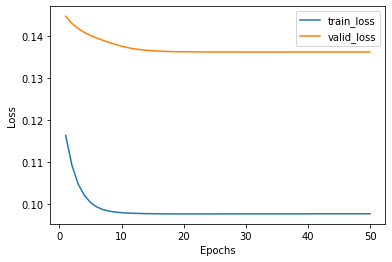

In [27]:
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [28]:
def plot_data(glm_zeta, net_zeta):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    #ax.plot(indices, predicted_zeta, color='blue', alpha=0.4)
    #ax.plot(indices, simulated_zeta, color='orange', alpha=0.4)
    
    ax.scatter(indices, net_zeta, color='blue', label='Neural Net Zeta')
    ax.scatter(indices, glm_zeta, color='orange', label='GLM Zeta')
    
    ax.set_title('Neural Net vs GLM Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()

    plt.show()


In [29]:
tstdl = DataLoader(test_set, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

In [30]:
model.eval()

data_iter = iter(tstdl)

number of samples: 5
Neural Net Zeta:
tensor([1.1808, 1.1813, 1.1817, 1.1822, 1.1826, 1.1830, 1.1835, 1.1839, 1.1843,
        1.1848, 1.1852, 1.1856, 1.1860, 1.1865, 1.1869, 1.1873, 1.1866, 1.1881,
        1.1885, 1.1889, 1.1893, 1.1897, 1.1901, 1.1904, 1.1908, 1.1912, 1.1916,
        1.1919, 1.1923, 1.1927, 1.1930, 1.1934, 1.1937, 1.1941, 1.1944, 1.1947,
        1.1951, 1.1954, 1.1957, 1.1960, 1.1963, 1.1966, 1.1969, 1.1972, 1.1975,
        1.1978, 1.1981, 1.1984, 1.1987, 1.1989, 1.1992, 1.1995, 1.1997, 1.2000,
        1.2002, 1.2005, 1.2007, 1.2009, 1.2000, 1.2014, 1.2016, 1.2018, 1.2020,
        1.2022])
GLM Zeta:
tensor([1.1416, 1.1419, 1.1422, 1.1426, 1.1429, 1.1432, 1.1436, 1.1439, 1.1442,
        1.1445, 1.1448, 1.1451, 1.1455, 1.1458, 1.1461, 1.1464, 0.9468, 1.1469,
        1.1472, 1.1475, 1.1478, 1.1481, 1.1484, 1.1486, 1.1489, 1.1492, 1.1494,
        1.1497, 1.1499, 1.1502, 1.1504, 1.1507, 1.1509, 1.1511, 1.1514, 1.1516,
        1.1518, 1.1520, 1.1522, 1.1525, 1.1527, 1.1529,

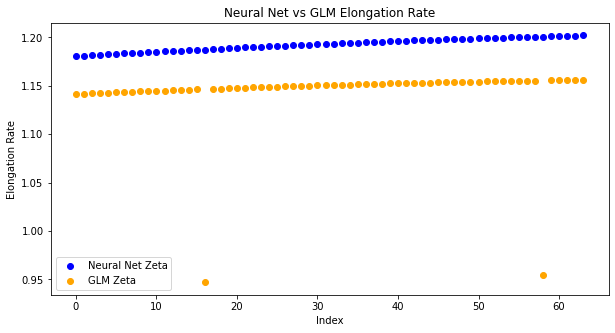

number of samples: 5
Neural Net Zeta:
tensor([1.2024, 1.2026, 1.2028, 1.2030, 1.2031, 1.2033, 1.2035, 1.2036, 1.2027,
        1.2039, 1.2041, 1.2042, 1.2044, 1.2045, 1.2046, 1.2047, 1.2049, 1.2050,
        1.2051, 1.2052, 1.2053, 1.2054, 1.2054, 1.2055, 1.2056, 1.2057, 1.2057,
        1.2058, 1.2059, 1.2059, 1.2060, 1.2060, 1.2061, 1.2061, 1.2061, 1.2061,
        1.2062, 1.2062, 1.2062, 1.2062, 1.2062, 1.2062, 1.2062, 1.2062, 1.2062,
        1.2061, 1.2061, 1.2061, 1.2061, 1.2060, 1.2060, 1.2059, 1.2059, 1.2058,
        1.2058, 1.2057, 1.2057, 1.2056, 1.2055, 1.2055, 1.2054, 1.2053, 1.2052,
        1.2051])
GLM Zeta:
tensor([1.1563, 1.1564, 1.1565, 1.1566, 1.1566, 1.1567, 1.1568, 1.1569, 0.9553,
        1.1570, 1.1570, 1.1571, 1.1571, 1.1572, 1.1572, 1.1573, 1.1573, 1.1573,
        1.1573, 1.1573, 1.1574, 1.1574, 1.1574, 1.1574, 1.1574, 1.1574, 1.1573,
        1.1573, 1.1573, 1.1573, 1.1573, 1.1572, 1.1572, 1.1571, 1.1571, 1.1570,
        1.1570, 1.1569, 1.1569, 1.1568, 1.1568, 1.1567,

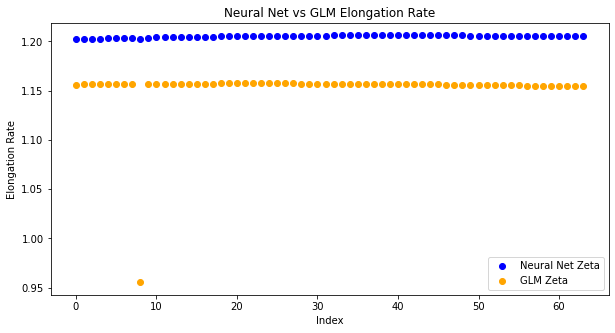

number of samples: 5
Neural Net Zeta:
tensor([1.2050, 1.2049, 1.2049, 1.2048, 1.2046, 1.2045, 1.2044, 1.2043, 1.2042,
        1.2041, 1.2040, 1.2038, 1.2037, 1.2036, 1.2035, 1.2033, 1.2032, 1.2030,
        1.2029, 1.2028, 1.2026, 1.2025, 1.2023, 1.2022, 1.2020, 1.2019, 1.2017,
        1.2015, 1.2014, 1.2012, 1.2010, 1.2009, 1.2007, 1.2005, 1.2004, 1.2002,
        1.2000, 1.1999, 1.1997, 1.1995, 1.1993, 1.1992, 1.1990, 1.1988, 1.1986,
        1.1985, 1.1983, 1.1981, 1.1979, 1.1977, 1.1975, 1.1974, 1.1972, 1.1970,
        1.1968, 1.1966, 1.1965, 1.1963, 1.1961, 1.1959, 1.1957, 1.1956, 1.1943,
        1.1952])
GLM Zeta:
tensor([1.1542, 1.1540, 1.1539, 1.1537, 1.1536, 1.1534, 1.1533, 1.1531, 1.1530,
        1.1528, 1.1526, 1.1525, 1.1523, 1.1522, 1.1520, 1.1518, 1.1516, 1.1515,
        1.1513, 1.1511, 1.1509, 1.1508, 1.1506, 1.1504, 1.1502, 1.1500, 1.1499,
        1.1497, 1.1495, 1.1493, 1.1491, 1.1489, 1.1487, 1.1486, 1.1484, 1.1482,
        1.1480, 1.1478, 1.1476, 1.1474, 1.1472, 1.1470,

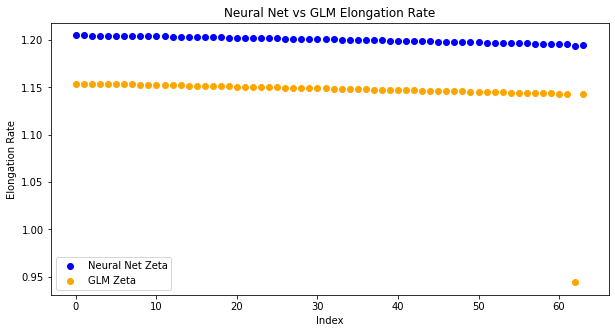

number of samples: 5
Neural Net Zeta:
tensor([1.1950, 1.1949, 1.1947, 1.1945, 1.1943, 1.1942, 1.1940, 1.1938, 1.1937,
        1.1935, 1.1933, 1.1932, 1.1930, 1.1928, 1.1927, 1.1925, 1.1923, 1.1922,
        1.1920, 1.1919, 1.1917, 1.1916, 1.1914, 1.1913, 1.1911, 1.1910, 1.1909,
        1.1907, 1.1906, 1.1905, 1.1903, 1.1902, 1.1901, 1.1900, 1.1898, 1.1897,
        1.1896, 1.1895, 1.1894, 1.1893, 1.1892, 1.1891, 1.1879, 1.1889, 1.1888,
        1.1887, 1.1886, 1.1885, 1.1884, 1.1884, 1.1872, 1.1882, 1.1882, 1.1881,
        1.1880, 1.1880, 1.1879, 1.1879, 1.1878, 1.1878, 1.1877, 1.1877, 1.1876,
        1.1876])
GLM Zeta:
tensor([1.1429, 1.1427, 1.1426, 1.1424, 1.1422, 1.1421, 1.1419, 1.1418, 1.1416,
        1.1415, 1.1413, 1.1412, 1.1410, 1.1409, 1.1407, 1.1406, 1.1405, 1.1403,
        1.1402, 1.1401, 1.1399, 1.1398, 1.1397, 1.1396, 1.1394, 1.1393, 1.1392,
        1.1391, 1.1390, 1.1389, 1.1388, 1.1387, 1.1386, 1.1385, 1.1384, 1.1384,
        1.1383, 1.1382, 1.1381, 1.1381, 1.1380, 1.1379,

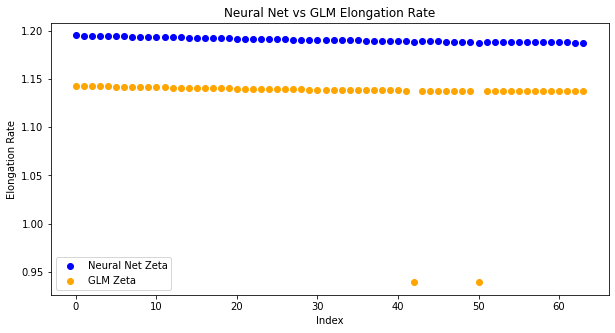

In [35]:
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)

    glm_zeta = inputs['Z_ji']
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())
    print("Neural Net Zeta:")
    print(net_zeta)

    print("GLM Zeta:")
    print(glm_zeta)

    plot_data(glm_zeta, net_zeta)

In [40]:
net_zeta = []
glm_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        net_zeta.append(torch.exp(rho_ji.cpu()))
        glm_zeta.append(batch['Z_ji'])

net_zeta = torch.cat(net_zeta, dim=0)
glm_zeta = torch.cat(glm_zeta, dim=0)
mae = F.l1_loss(net_zeta.squeeze(), glm_zeta)
mse = F.mse_loss(net_zeta.squeeze(), glm_zeta)

correlation_coefficient = np.corrcoef(glm_zeta, net_zeta.squeeze())[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Correlation Coefficient: 0.8637969062585605
Mean Absolute Error: 0.0510
Mean Squared Error: 0.0062


In [41]:
def density_plot(glm_zeta, net_zeta, gene_id):
    sns.kdeplot(x=glm_zeta, y=net_zeta, fill=True, cmap="Blues")
        
    plt.plot([min(glm_zeta), max(glm_zeta)], [min(net_zeta), max(net_zeta)], color='red')  # Diagonal line
    
    plt.xlim([min(glm_zeta), max(glm_zeta)])
    plt.ylim([min(net_zeta), max(net_zeta)])


    plt.xlabel('GLM Elongation Rate')
    plt.ylabel('Neural Net Elongation Rate')
    plt.title(gene_id)
    plt.show()

In [42]:
def scatterplot(net_zeta, glm_zeta, gene_id, log_scale, zoom):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    min_val = min(min(net_zeta), min(glm_zeta))
    max_val = max(max(net_zeta), max(glm_zeta))

    if zoom:
        plt.xlim(0.75, 1.25)
        plt.ylim(0.75, 1.25)
    else:
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
    
    if log_scale:
        ax.scatter(np.log(net_zeta), np.log(glm_zeta), s=5)        
    else:
        ax.scatter(net_zeta, glm_zeta, s=5)
    
    ax.set_title(gene_id)
    ax.set_xlabel('Neural Net Zeta')
    ax.set_ylabel('GLM Zeta')
    ax.legend()

    plt.show()


In [46]:
def create_gene_id_mapping(dataset, indices):
    gene_id_map = {}
    for idx in indices:
        data = dataset[idx]
        gene_id = data['GeneId']

        if gene_id not in gene_id_map:
            gene_id_map[gene_id] = [idx]
        else:
            gene_id_map[gene_id].append(idx)

    return gene_id_map

test_dic = create_gene_id_mapping(dataset, test_idx)

number of samples: 8000


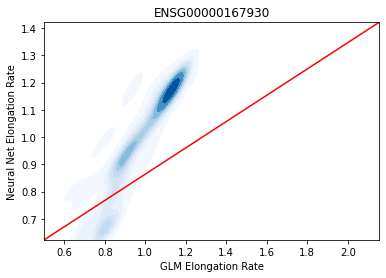

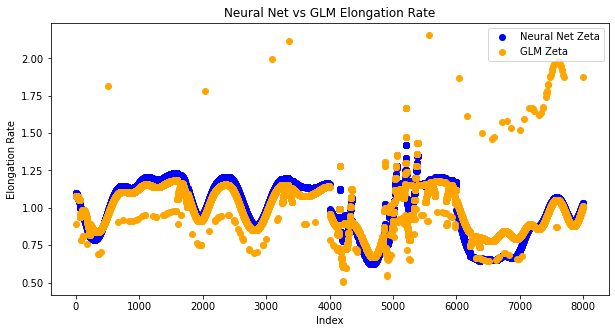

number of samples: 10168


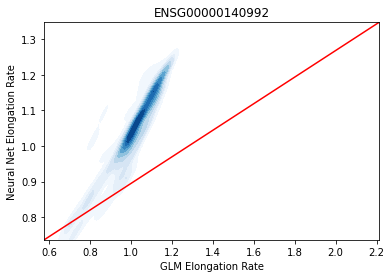

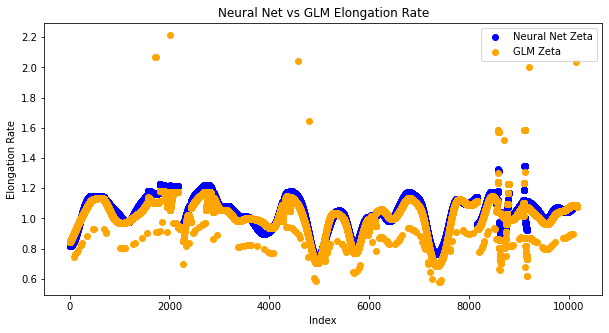

In [47]:
for gene_id, indices in test_dic.items():
    gene_id_subset = Subset(dataset, indices)
    test_loader = DataLoader(gene_id_subset, batch_size=len(indices))
    for batch in test_loader:
        model.eval()
        print("number of samples: " + str(len(indices)))

        with torch.no_grad():
            y_inputs = batch['Y_ji'].to(device)
            rho_ji = model(y_inputs)

        glm_zeta = batch['Z_ji']
        # convert log(Z) outputs to Z
        net_zeta = torch.exp(rho_ji.cpu().squeeze())
        
        density_plot(glm_zeta, net_zeta, gene_id)
        
        #scatterplot(predicted_zeta, simulated_zeta, gene_id, False, False)
        
        plot_data(glm_zeta, net_zeta)
        